## Imports

In [2]:
import torch
from torch.utils.model_zoo import load_url
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
%config InlineBackend.figure_format='retina'
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib as mpl
import pylab as pl

import sys
from blazeface import FaceExtractor, BlazeFace
from architectures import fornet,weights
from isplutils import utils
from tqdm import tqdm

import pandas as pd
import numpy as np

In [3]:
torch.__version__

'1.7.1'

In [4]:
## Functions

In [19]:
def variables(ds, splt):
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    face_policy = 'scale'
    face_size = 224
    tag = "net-EfficientNetB4_traindb-"+ds+splt+"_face-scale_size-224_seed-41_1"

    net = getattr(fornet,"EfficientNetB4")()
    net.load_state_dict(torch.load("weights/binclass/"+tag+"/bestval.pth", map_location=device)['net'])
    net.eval().to(device)
    return tag, device, net, face_policy, face_size

def transformers(device, net, face_policy, face_size):
    transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

    facedet = BlazeFace().to(device)
    facedet.load_weights("blazeface/blazeface.pth")
    facedet.load_anchors("blazeface/anchors.npy")
    face_extractor = FaceExtractor(facedet=facedet)
    return transf, face_extractor

def load_df_extract_face2(tag, device, ds):
    # Get which images where used for test
    test_folder = torch.load("weights/binclass/"+tag+"/bestval.pth", map_location=device)['test_videos_used'] #it005500
    test_folder = test_folder[0]
    # Load the dataframe
    face_folder = "../output/"+ds+"/faces"
    df = pd.read_pickle("../output/"+ds+"/dfs/from_video_0_to_video_0.pkl")
    test_df = df[df.video.isin(test_folder)]
    
    imgs_face = []
    for index in tqdm(range(len(test_df))):
        path = face_folder+'/'+test_df.index[index]
        img = Image.open(path)
        img_faces = face_extractor.process_image(img=img)
        if len(img_faces['faces']) > 0:
            img_face = img_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace
        imgs_face.append(img_face)
        
    return test_folder, test_df, imgs_face, face_folder

def load_df_extract_face(tag, device, ds):
    # Get which images where used for test
    test_folder = torch.load("weights/binclass/"+tag+"/bestval.pth", map_location=device)['test_videos_used'] #it005500
    test_folder = test_folder[0]
    # Load the dataframe
    face_folder = "../output/"+ds+"/faces"
    df = pd.read_pickle("../output/"+ds+"/dfs/from_video_0_to_video_0.pkl")
    test_df = df[df.video.isin(test_folder)]
    
    imgs_face = []
    for index in tqdm(range(len(test_df))):
        path = face_folder+'/'+test_df.index[index]
        img = Image.open(path)
        img_face = np.asarray(img)
        imgs_face.append(img_face)
        
    return test_folder, test_df, imgs_face, face_folder

def compute_truth_pred_save(test_df, imgs_face, device, tag, transf):
    divisor=100
    all_preds = []
    for i in tqdm(range(len(test_df)//divisor)):
        faces_t = torch.stack([transf(image=im)['image'] for im in imgs_face[i*divisor:(i+1)*divisor]])
        with torch.no_grad():
            faces_pred = torch.sigmoid(net(faces_t.to(device))).cpu().numpy().flatten()
        all_preds.append(faces_pred)

    faces_t = torch.stack([transf(image=im)['image'] for im in imgs_face[len(test_df)//divisor*divisor:]])
    with torch.no_grad():
        faces_pred = torch.sigmoid(net(faces_t.to(device))).cpu().numpy().flatten()
    all_preds.append(faces_pred)
    all_preds = np.array([i for tab in all_preds for i in tab])
    all_truth = np.array(test_df.label)*1.0

    f = open("runs/binclass/"+tag+"/test_preds.txt", "a")
    f.write(str(all_truth.tolist()))
    f.write("\n")
    f.write(str(all_preds.tolist()))
    f.write("\n\n")
    f.close()
    
    return all_truth, all_preds

def load_truth_pred(tag):
    with open("runs/binclass/"+tag+"/test_preds.txt") as f:
        content = f.readlines()
    all_truth = [float(i) for i in content[0][1:-2].split(',')]
    all_preds = [float(i) for i in content[1][1:-2].split(',')]
    return all_truth, all_preds

def display_n_results(n, test_df, face_folder, all_truth, all_preds, face_extractor, name):
    show_n_first = n
    indices = np.random.choice(len(test_df), show_n_first, replace=False)
    indices = np.array([int(i) for i in indices])

    for index in indices:
        path = face_folder+'/'+test_df.index[index]
        img = Image.open(path)

        fig, ax = plt.subplots(1,4,figsize=(12,4))
        fig.tight_layout()
        # Left image
        ax[0].imshow(img)

        # Central image
        ax[1].imshow(img)
        ax[1].scatter(x=[test_df.kp1x[index], test_df.kp2x[index], test_df.kp3x[index], test_df.kp4x[index], test_df.kp5x[index], test_df.kp6x[index]],
                      y=[test_df.kp1y[index], test_df.kp2y[index], test_df.kp3y[index], test_df.kp4y[index], test_df.kp5y[index], test_df.kp6y[index]],
                      c=['b','g', 'r','c', 'm', 'y'], s=40)
        ax[1].axhline(y=test_df.top[index], color='w', linestyle='-')
        ax[1].axhline(y=test_df.bottom[index], color='w', linestyle='-')
        ax[1].axvline(x=test_df.left[index], color='w', linestyle='-')
        ax[1].axvline(x=test_df.right[index], color='w', linestyle='-')

            # Right image
        img_faces = face_extractor.process_image(img=img)
        if len(img_faces['faces']) == 0:
            ax[2].text(0.5, 0.5, 'NO FACE DETECTED', horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)
        else:
            img_face = img_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace
            ax[2].imshow(img_face)

            pred = all_preds[index]
            truth = all_truth[index]
            ax[3].text(0.5, 0.52, 'PRED: '+str(round(pred, 5)), horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes, weight='bold')
            ax[3].text(0.5, 0.45, 'TRUTH: '+str(truth), horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes, weight='bold')
            if truth==1:
                txt='FAKE'
            else:
                txt='REAL'
            ax[3].text(0.5, 0.35, txt, horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes, weight='bold')
            if pred>0.5:
                txt='FAKE'
            else:
                txt='REAL'
            ax[3].text(0.5, 0.62, txt, horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes)

            ax[3].axis('off')
            normal = pl.Normalize(0,1)
            if truth==1:
                cm = pl.cm.RdYlGn
                colors = cm(normal(pred))
            else:
                cm = pl.cm.RdYlGn_r
                colors = cm(normal(pred))
            colors = (colors[0], colors[1], colors[2], 0.8)
            ax[3].add_patch(mpl.patches.Rectangle((0.14,0.4), 0.73, 0.18, color=colors))

        plt.savefig('../images/'+name+'.png', format='png', dpi=100)
        plt.show()

        
        
def plot_roc(ds, all_truth, all_preds, name):
    #mpl.rcParams.update(mpl.rcParamsDefault)
    params = {'legend.fontsize': 'xx-large',
              #'figure.figsize': (15, 5),
             'axes.labelsize': 'xx-large',
             'axes.titlesize':'xx-large',
             'xtick.labelsize':'xx-large',
             'ytick.labelsize':'xx-large', 
             'lines.linewidth':2.0
             }
    pl.rcParams.update(params)

    fpr, tpr, _ = roc_curve(all_truth, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(20, 15))

    plt.plot(fpr, tpr, label='area = %0.5f' % roc_auc)

    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate / FallOut')
    plt.ylabel('True Positive Rate / Recall')
    plt.title(ds.upper()+' - ROC Curves for different rounds')
    plt.legend(loc="lower right")
    
    tp = sum(np.where(np.logical_and(np.array(all_truth)== 1, np.array(all_preds)>0.5), 1, 0))
    tn = sum(np.where(np.logical_and(np.array(all_truth)== 0, np.array(all_preds)<0.5), 1, 0))
    fp = sum(np.where(np.logical_and(np.array(all_truth)== 0, np.array(all_preds)>0.5), 1, 0))
    fn = sum(np.where(np.logical_and(np.array(all_truth)== 1, np.array(all_preds)<0.5), 1, 0))
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1score = 2*((tp)/(tp+fp)*(tp)/(tp+fn))/((tp)/(tp+fp)+(tp)/(tp+fn))
    
    plt.plot([], [], ' ', label="Accuracy:  "+str(round(accuracy, 4)))
    plt.plot([], [], ' ', label="Precision: "+str(round(precision, 4)))
    plt.plot([], [], ' ', label="Recall:    "+str(round(recall, 4)))
    plt.plot([], [], ' ', label="F1-Score:  "+str(round(f1score, 4)))

    
    plt.savefig('../images/'+name+'.png', format='png', dpi=100)
    plt.show()

    
    

## DFDC

In [7]:
ds = 'dfdc'
splt='-35-5-10'
#ds = 'celebdf'
#splt='-35-5-10'
#ds = 'ffpp'
#splt='-c23-720-140-140'

In [8]:
tag, device, net, face_policy, face_size = variables(ds, splt)

Loaded pretrained weights for efficientnet-b4


In [9]:
transf, face_extractor = transformers(device, net, face_policy, face_size)

In [32]:
test_folder, test_df, imgs_face, face_folder = load_df_extract_face(tag, device, ds)
np.save('_imgs_face.npy', np.array(imgs_face, dtype=object, copy=False))

100%|██████████| 2592/2592 [00:11<00:00, 227.28it/s]


- Transfer `imgs_face.npy` to GPU root
- Change and run `_test.py`on GPU
- Tranfer `runs/binclass/tag/test_preds.txt` to computer

In [33]:
all_truth, all_preds = compute_truth_pred_save(test_df, imgs_face, device, tag, transf)
#all_truth, all_preds = load_truth_pred(tag)
print(len(all_preds))
print(len(test_df))

100%|██████████| 25/25 [08:24<00:00, 20.17s/it]


2592
2592


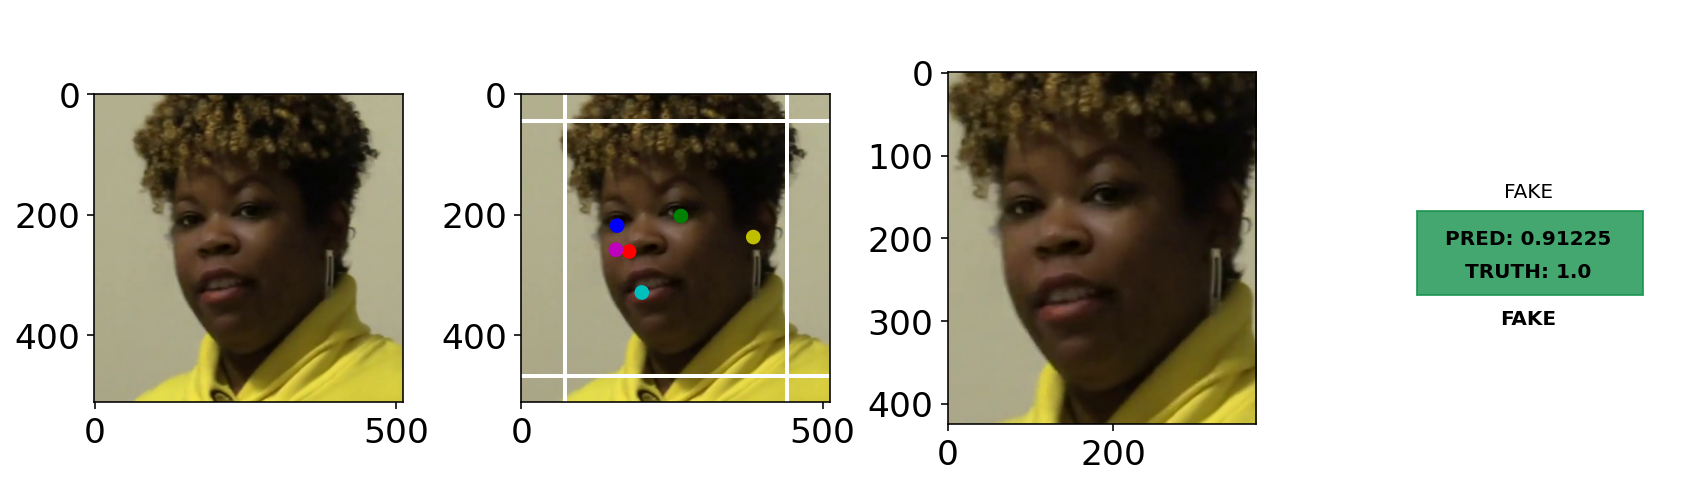

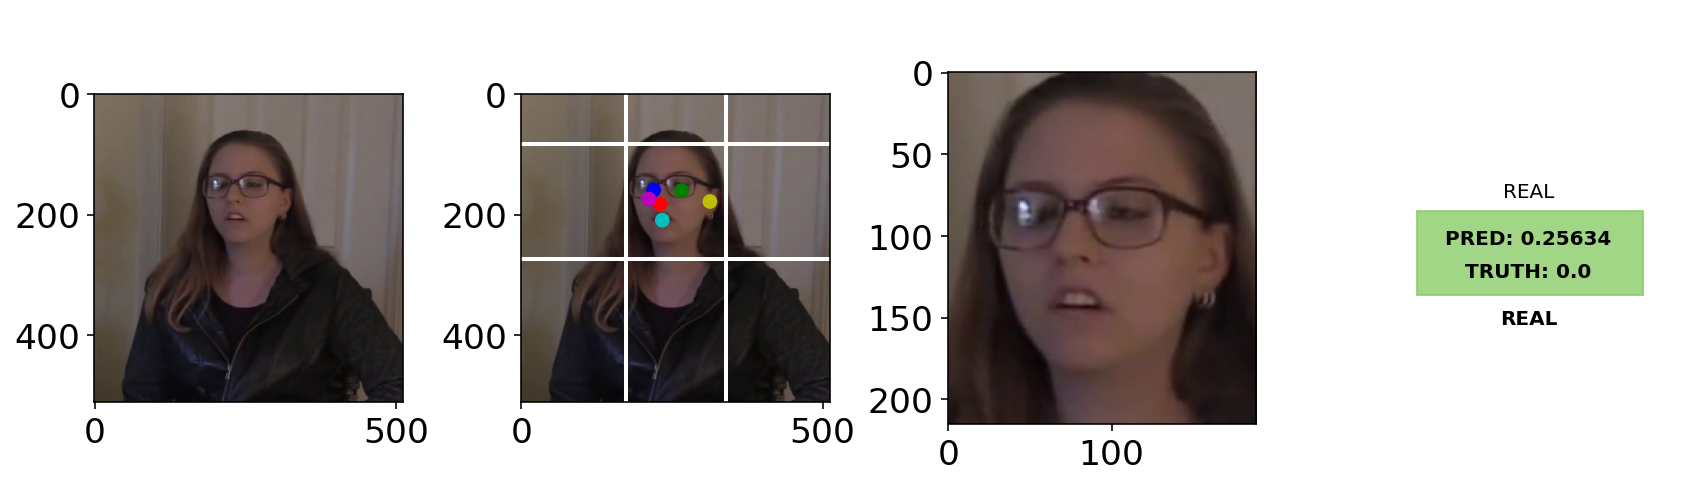

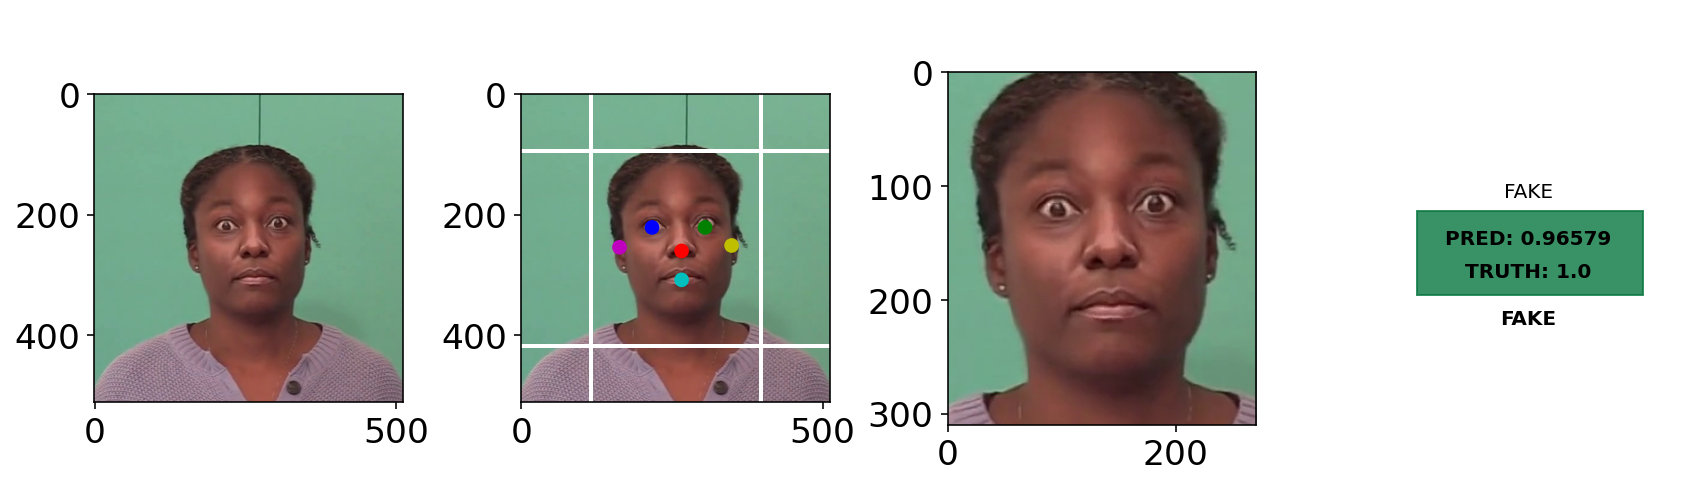

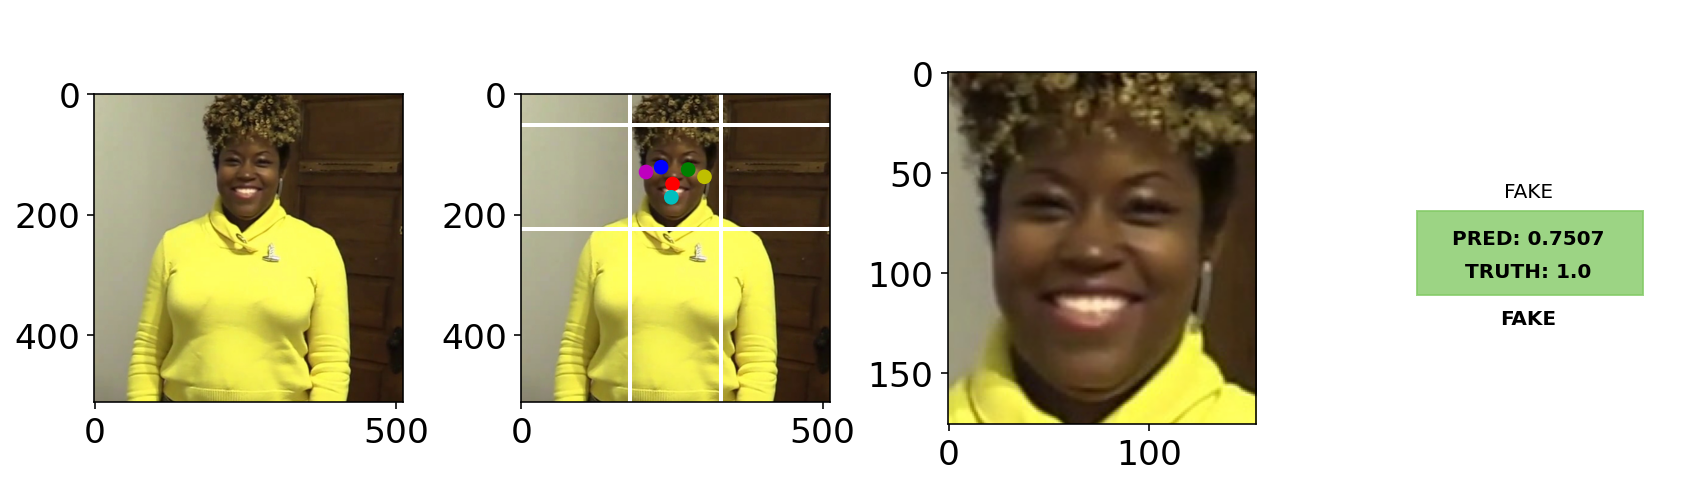

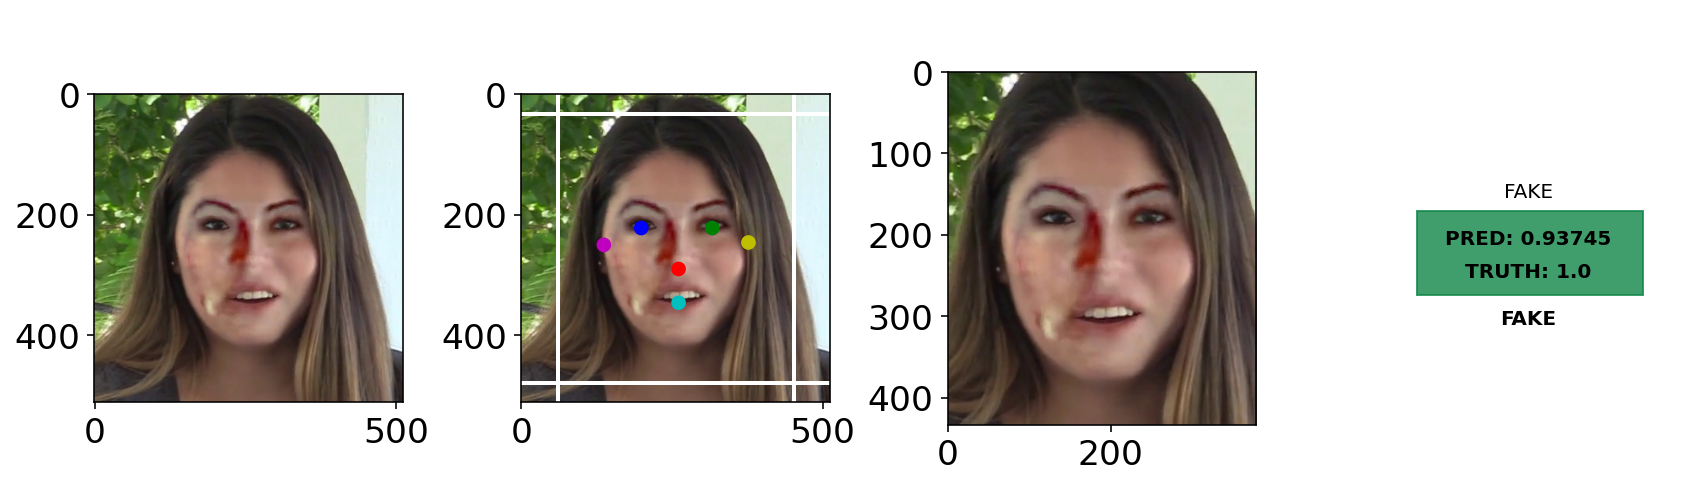

In [35]:
display_n_results(5, test_df, face_folder, all_truth, all_preds, face_extractor, 'DFDC_ICPR_simple_extraction_RES')

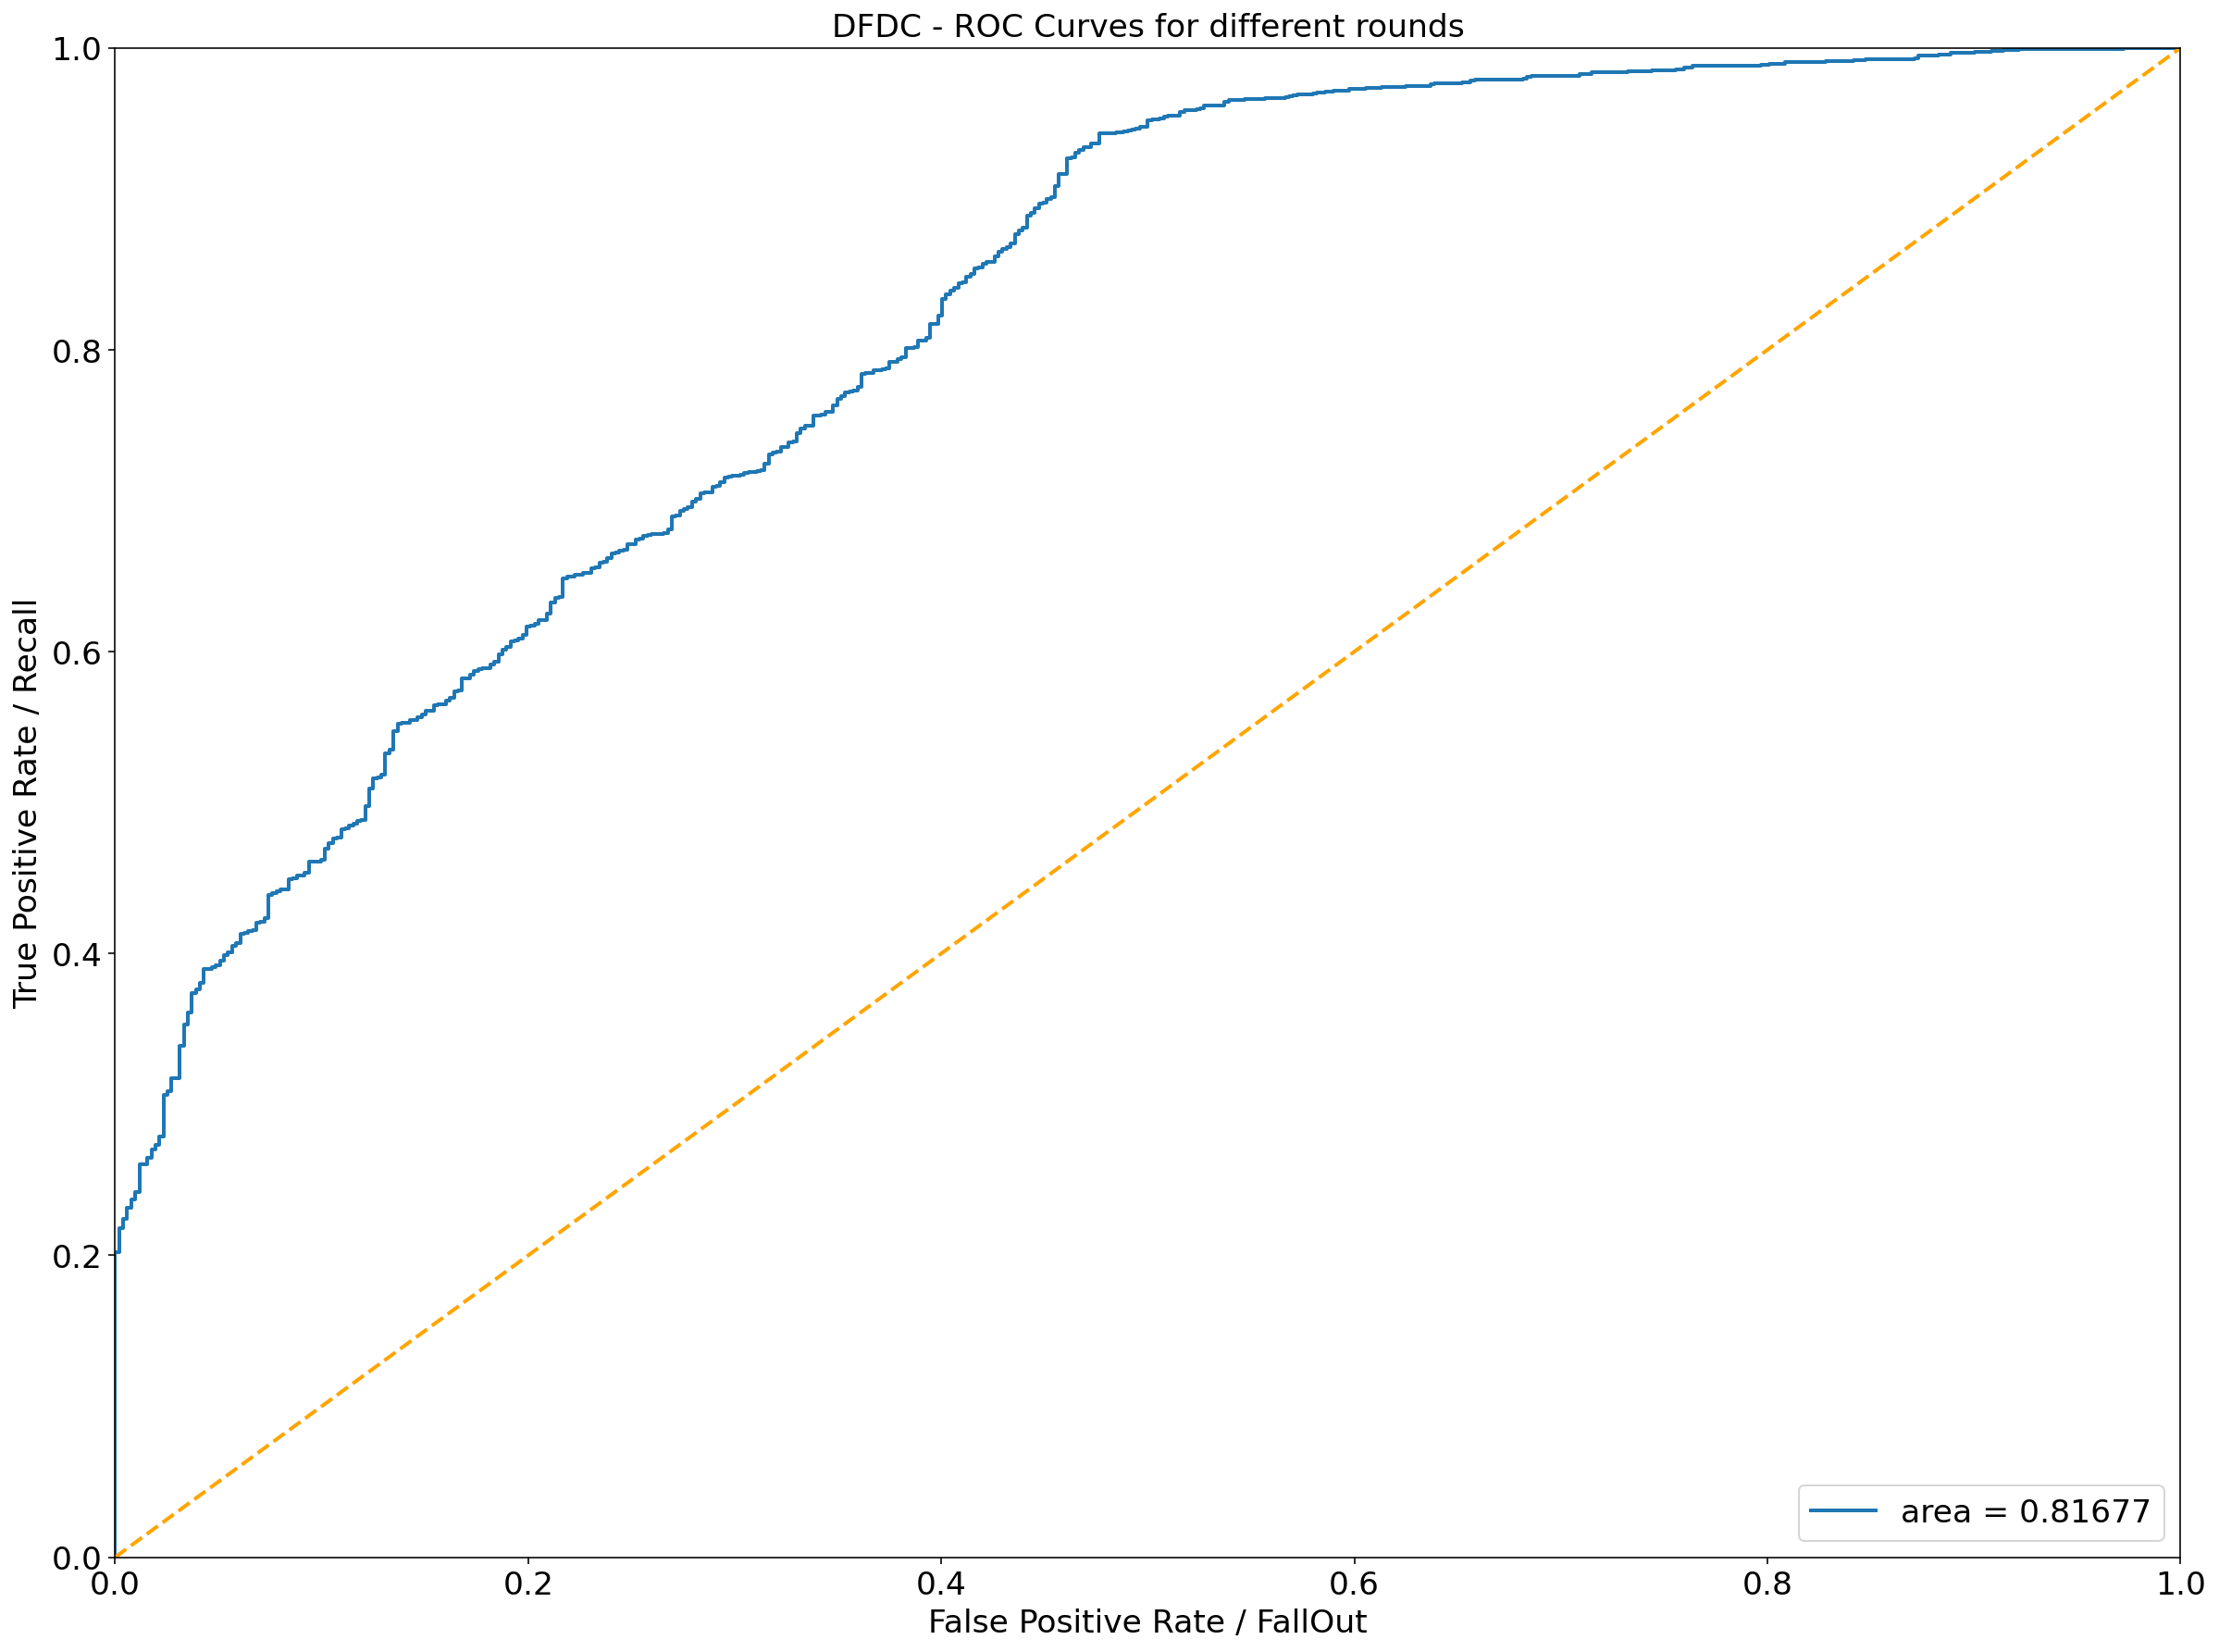

Accuracy:  0.8302469135802469
Precision: 0.890104662226451
Recall:    0.8995192307692308
F1-Score:  0.8947871831659493


In [36]:
plot_roc(ds, all_truth, all_preds, 'DFDC_ICPR_simple_extraction_ROC')

## FFPP

In [15]:
#ds = 'dfdc'
#splt='-35-5-10'
#ds = 'celebdf'
#splt='-35-5-10'
ds = 'ffpp'
splt='-c23-720-140-140'

In [16]:
tag, device, net, face_policy, face_size = variables(ds, splt)

Loaded pretrained weights for efficientnet-b4


In [17]:
transf, face_extractor = transformers(device, net, face_policy, face_size)

In [18]:
test_folder, test_df, imgs_face, face_folder = load_df_extract_face2(tag, device, ds)
np.save('_imgs_face.npy', np.array(imgs_face, dtype=object, copy=False))

100%|██████████| 26879/26879 [15:26<00:00, 29.02it/s]


- Transfer `imgs_face.npy` to GPU root
- Change and run `_test.py`on GPU
- Tranfer `runs/binclass/tag/test_preds.txt` to computer

In [20]:
#all_truth, all_preds = compute_truth_pred_save(test_df, imgs_face, device, tag, transf)
all_truth, all_preds = load_truth_pred(tag)
print(len(all_preds))
print(len(test_df))

26879
26879


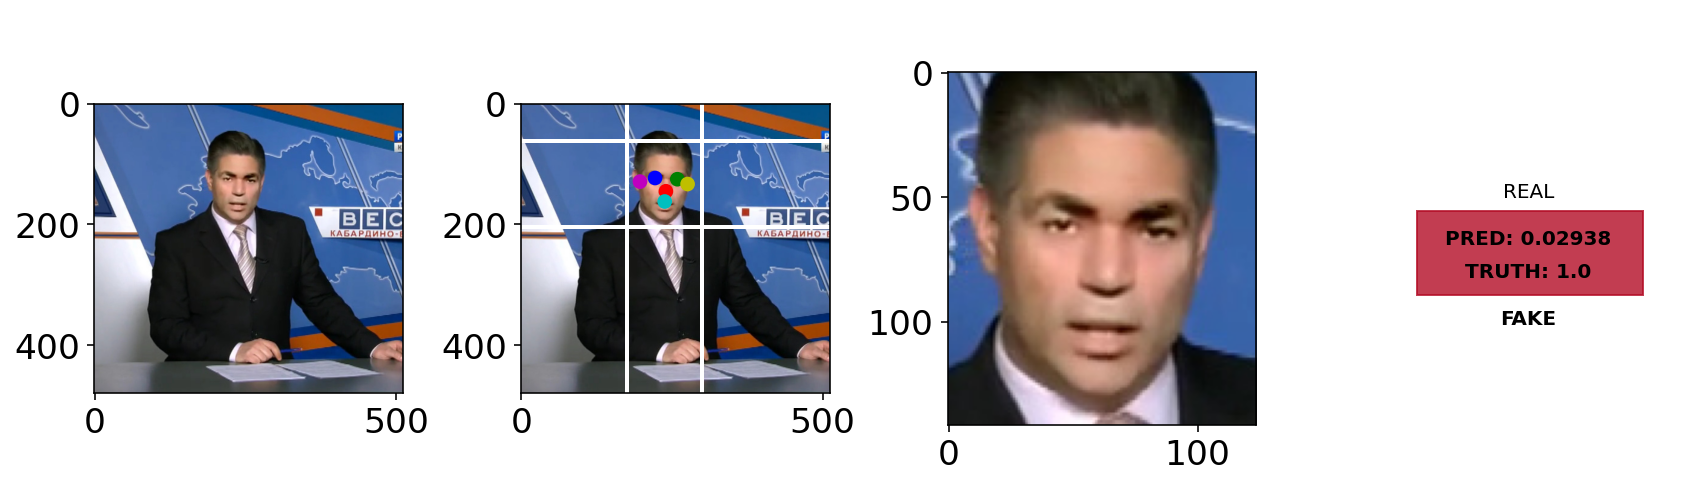

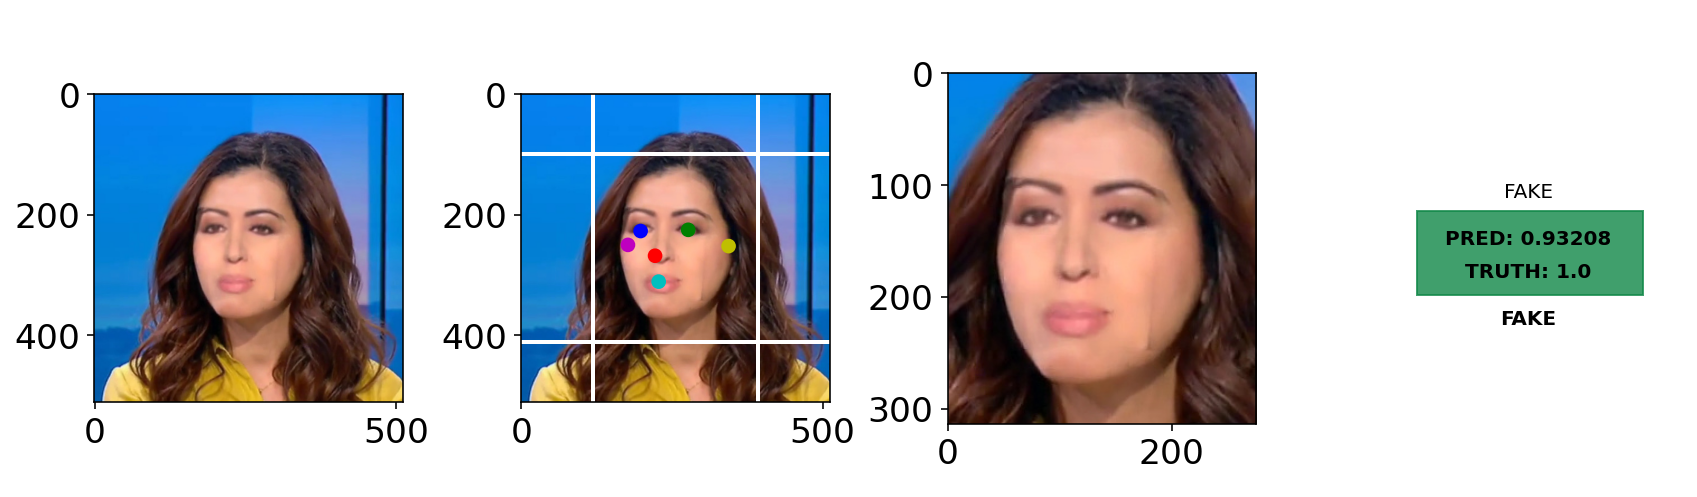

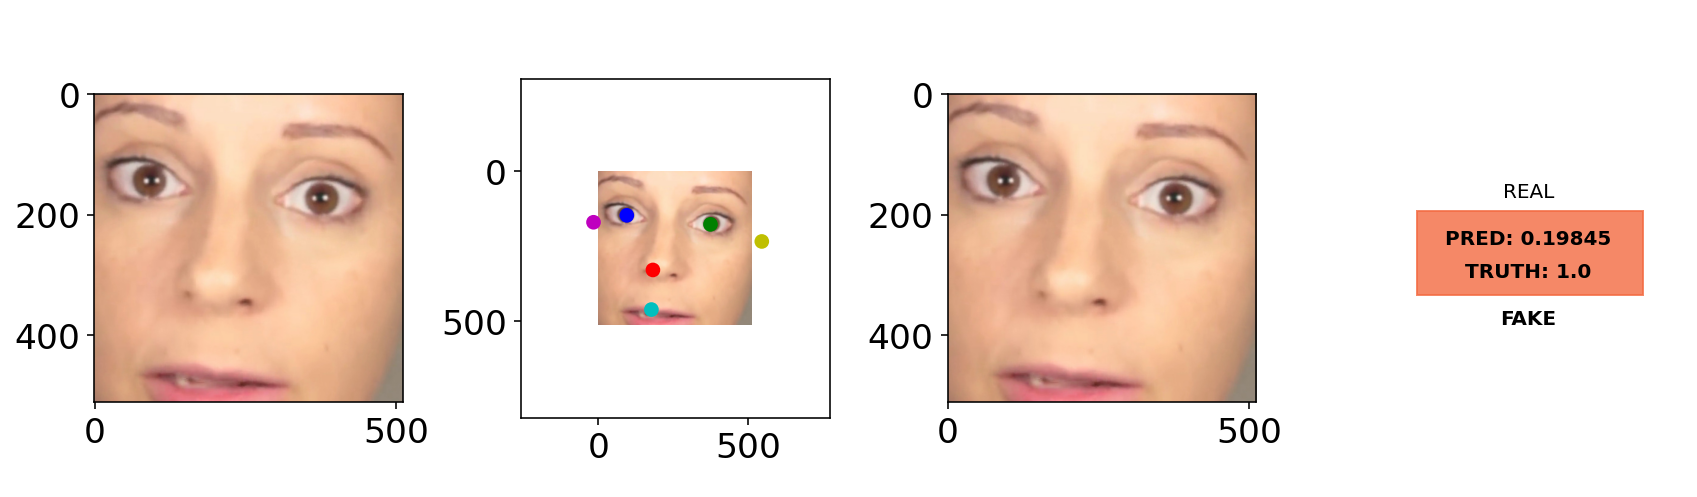

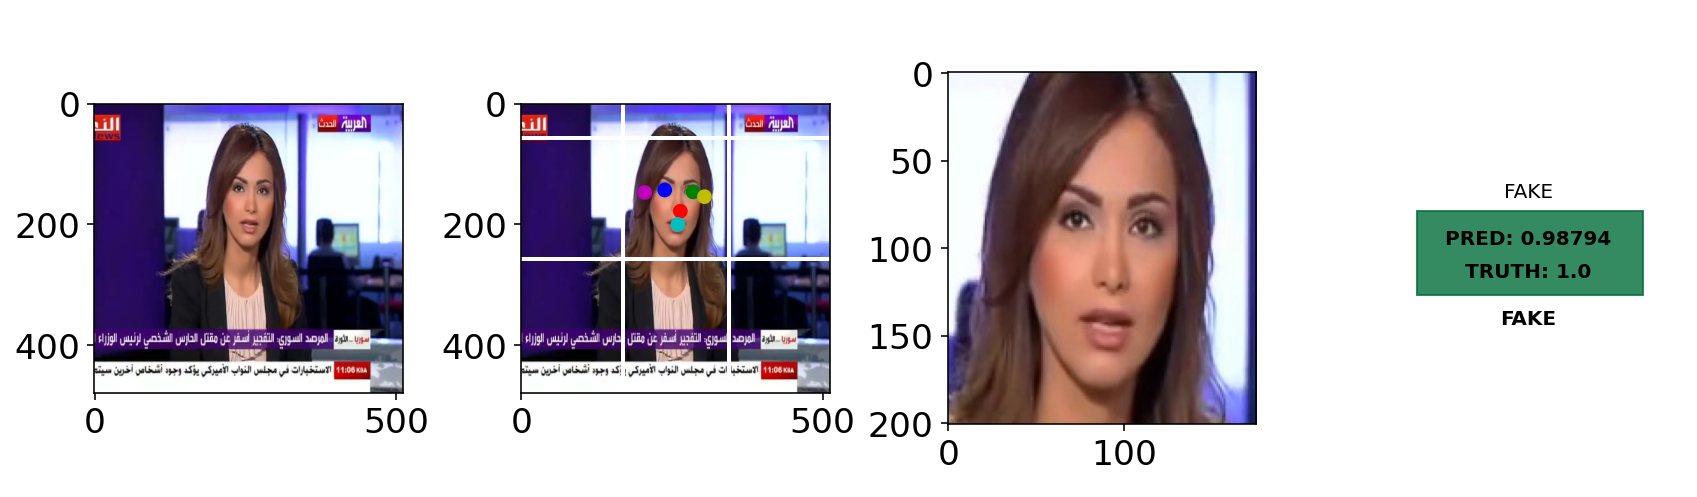

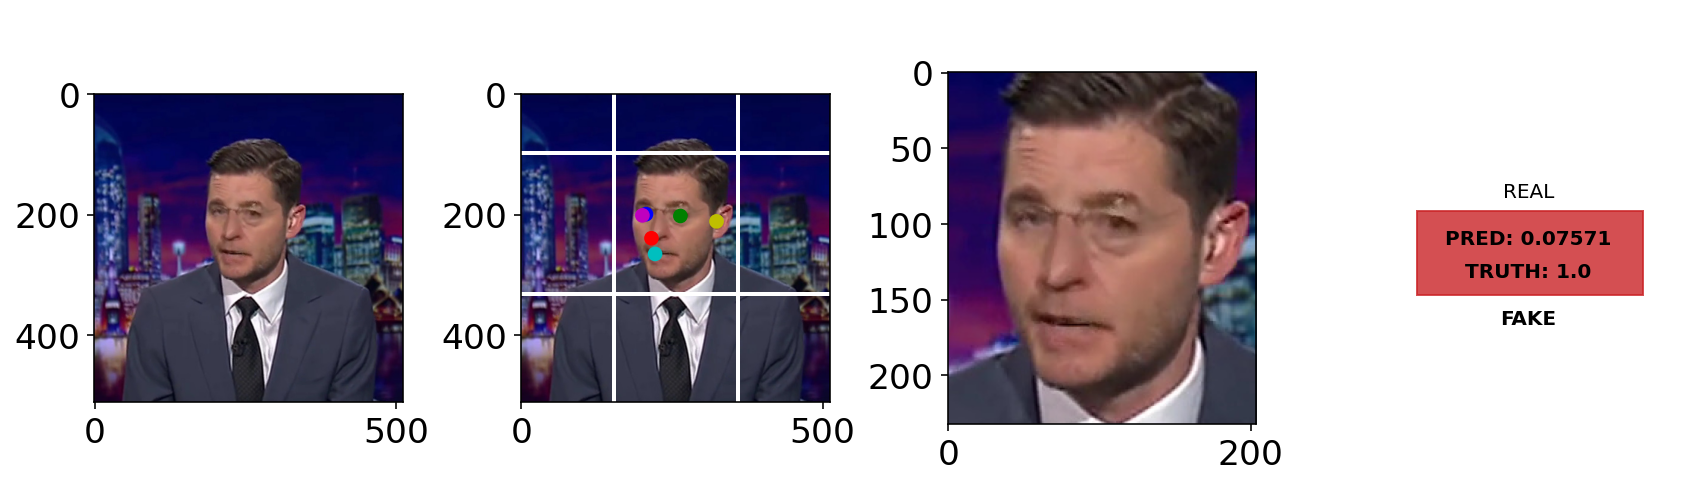

In [21]:
display_n_results(5, test_df, face_folder, all_truth, all_preds, face_extractor, 'FFPP_ICPR_double_extraction_RES')

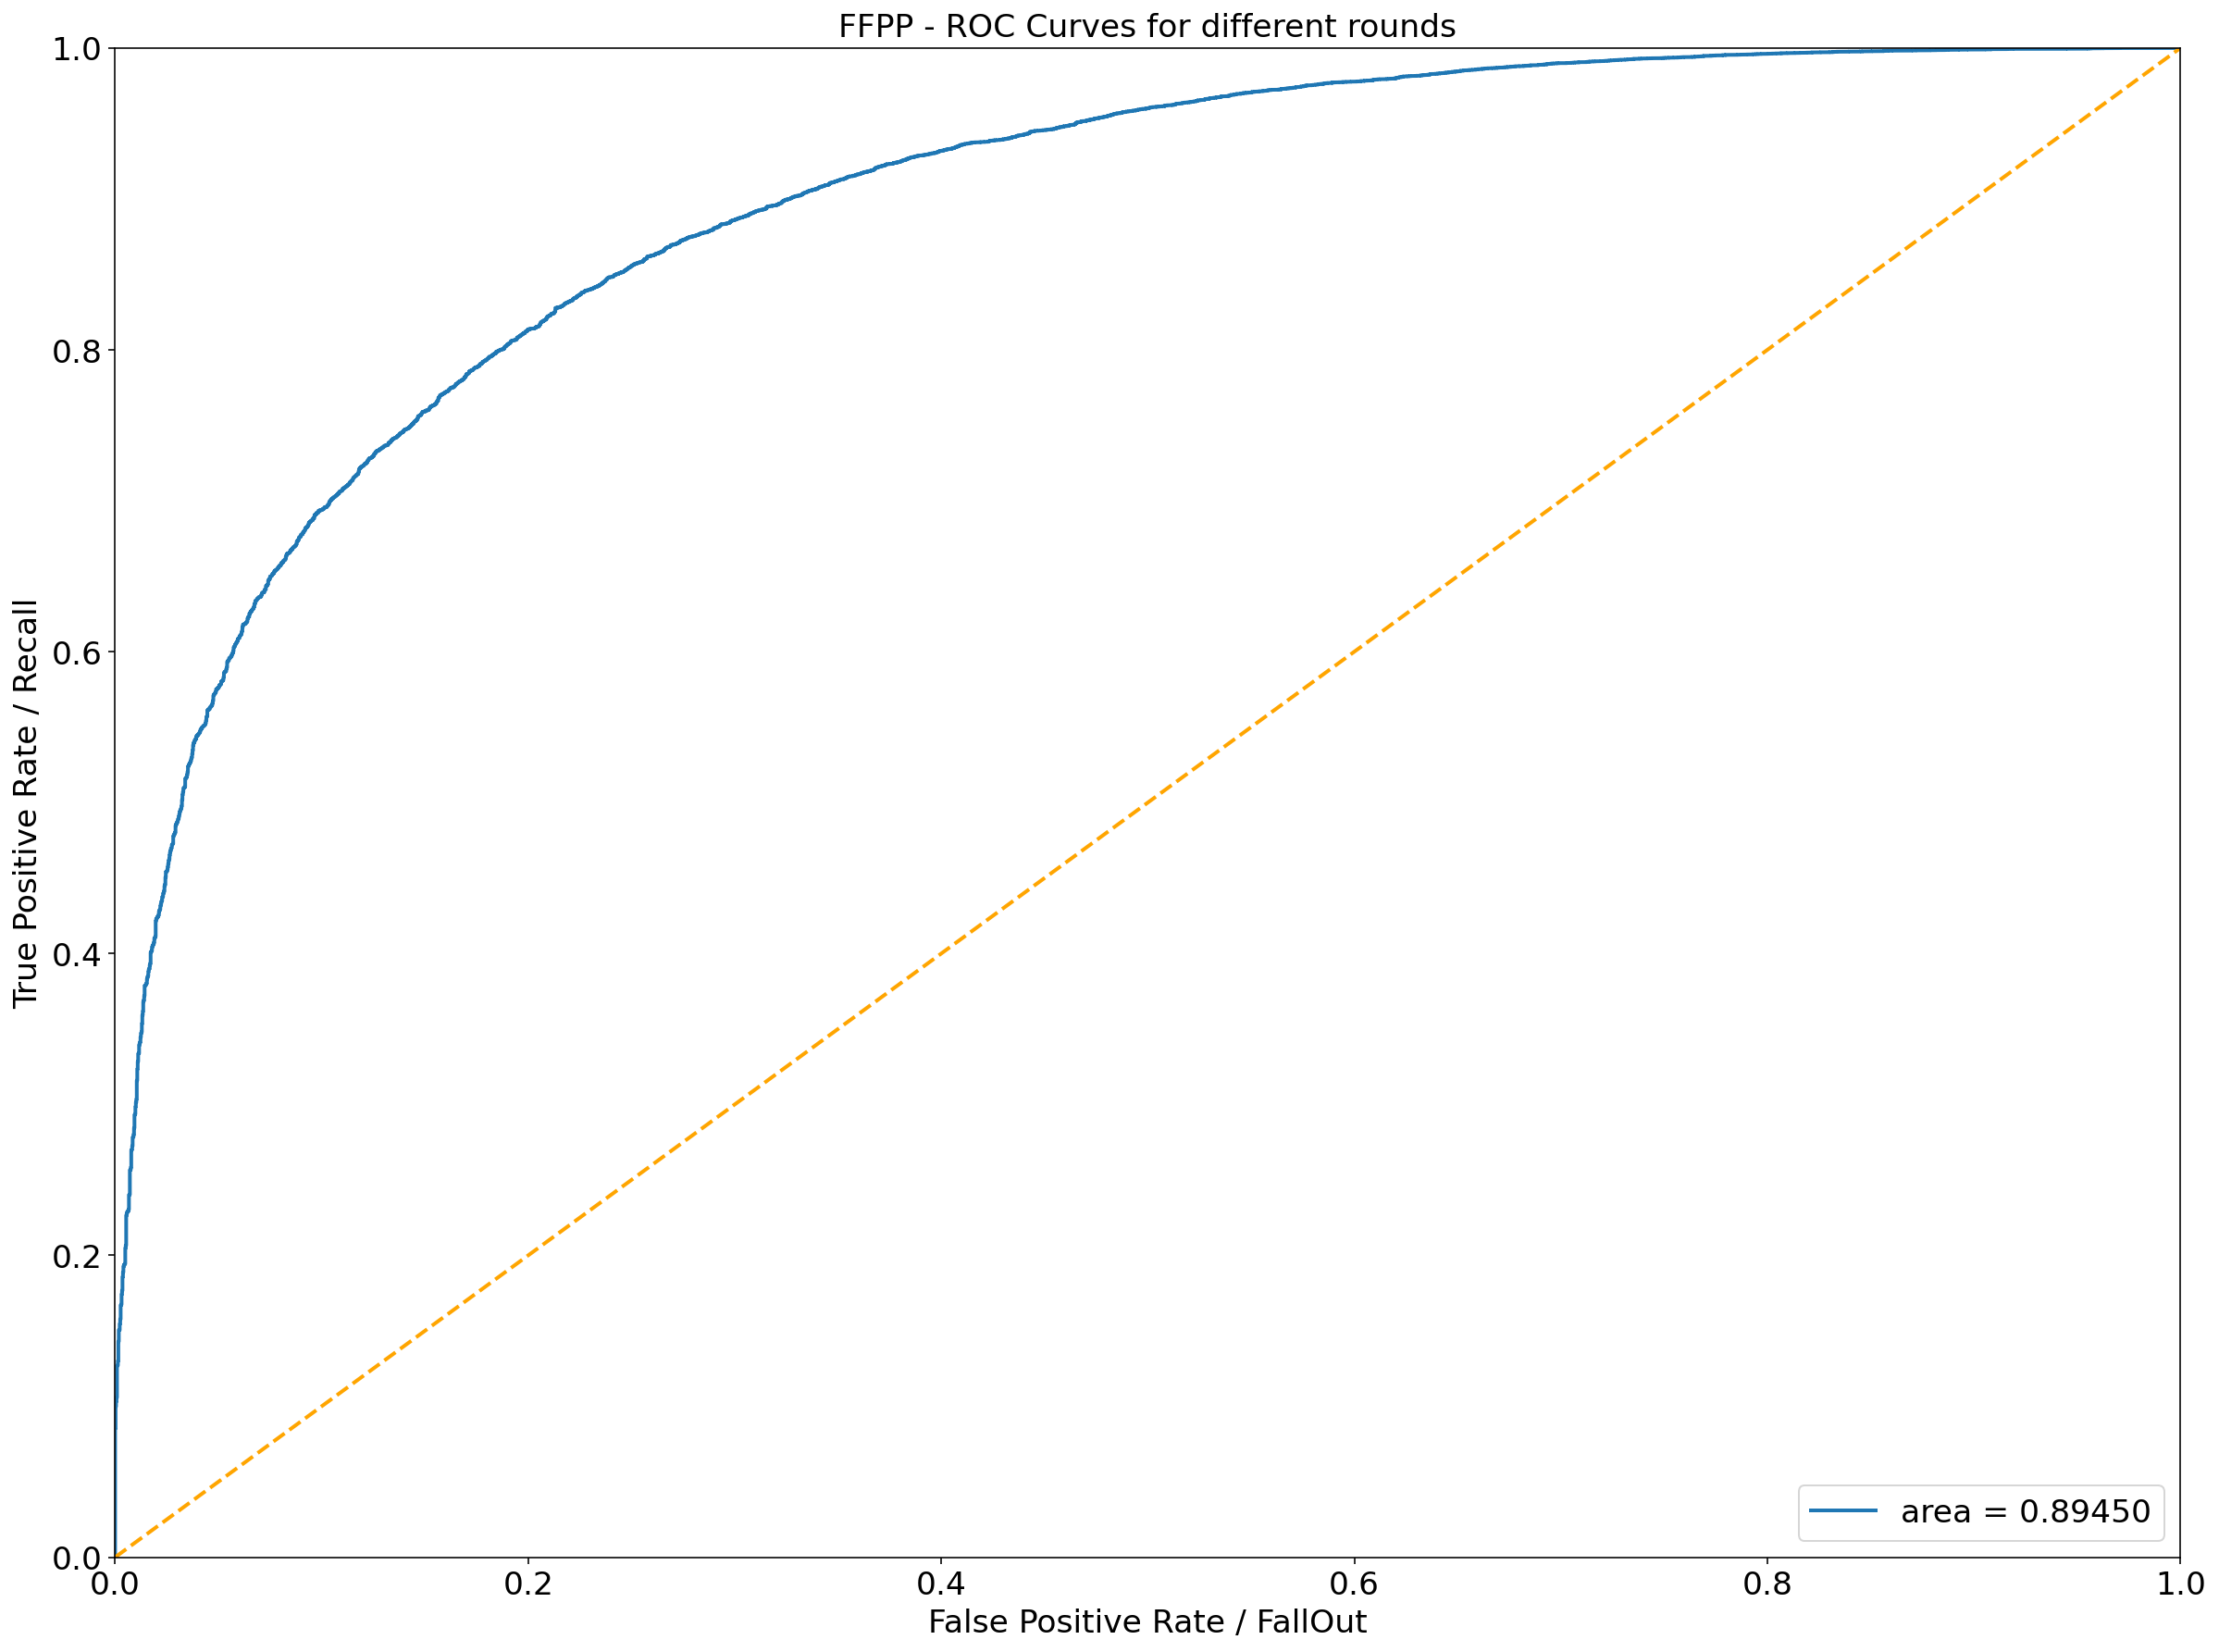

In [22]:
plot_roc(ds, all_truth, all_preds, 'FFPP_ICPR_double_extraction_ROC')

## CELEBDF

In [33]:
#ds = 'dfdc'
#splt='-35-5-10'
ds = 'celebdf'
splt='-35-5-10'
#ds = 'ffpp'
#splt='-c23-720-140-140'

In [34]:
tag, device, net, face_policy, face_size = variables(ds, splt)

Loaded pretrained weights for efficientnet-b4


In [35]:
transf, face_extractor = transformers(device, net, face_policy, face_size)

In [1]:
#test_folder, test_df, imgs_face, face_folder = load_df_extract_face(tag, device, ds)
#np.save('_imgs_face.npy', np.array(imgs_face, dtype=object, copy=False))

In [ ]:
np.save('_imgs_face.npy', np.array(imgs_face, dtype=object, copy=False))

- Transfer `imgs_face.npy` to GPU root
- Change and run `_test.py`on GPU
- Tranfer `runs/binclass/tag/test_preds.txt` to computer

In [30]:
#all_truth, all_preds = compute_truth_pred_save(test_df, imgs_face, device, tag, transf)
all_truth, all_preds = load_truth_pred(tag)
print(len(all_preds))
print(len(test_df))

26879
26879


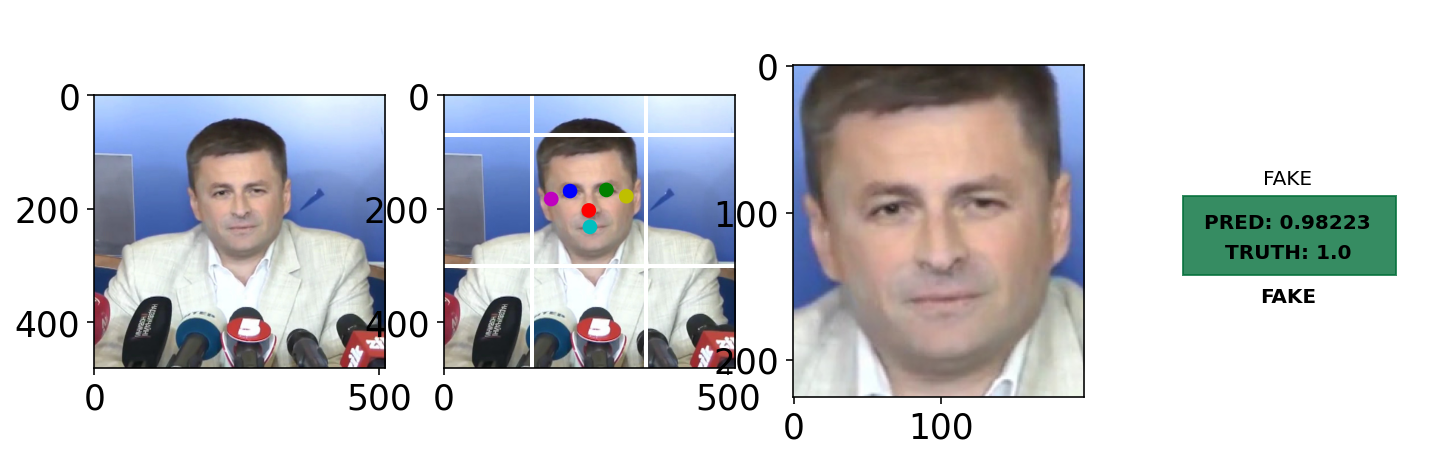

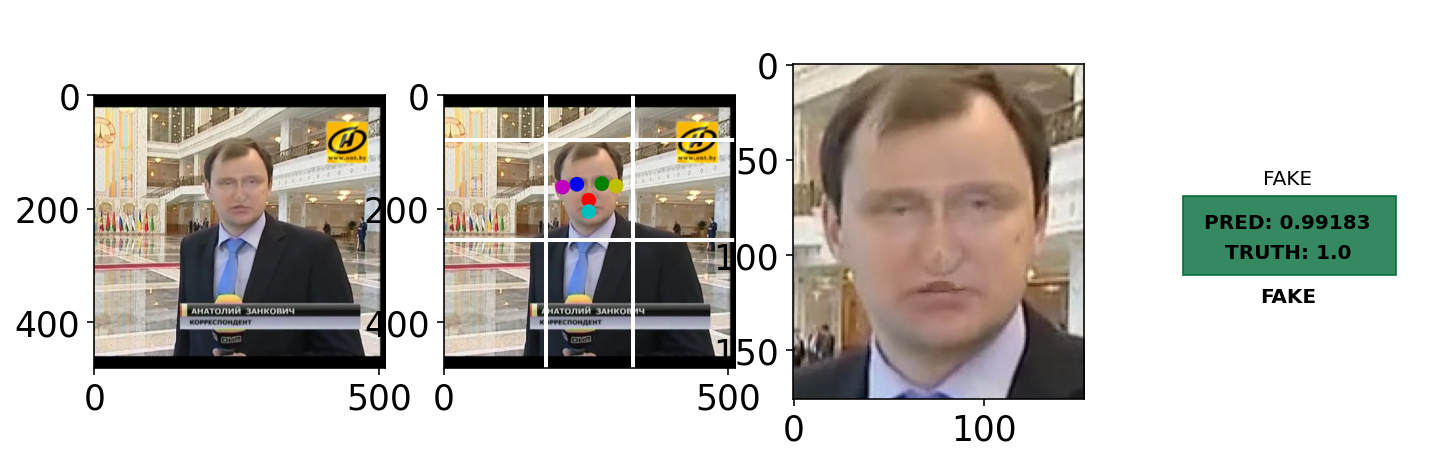

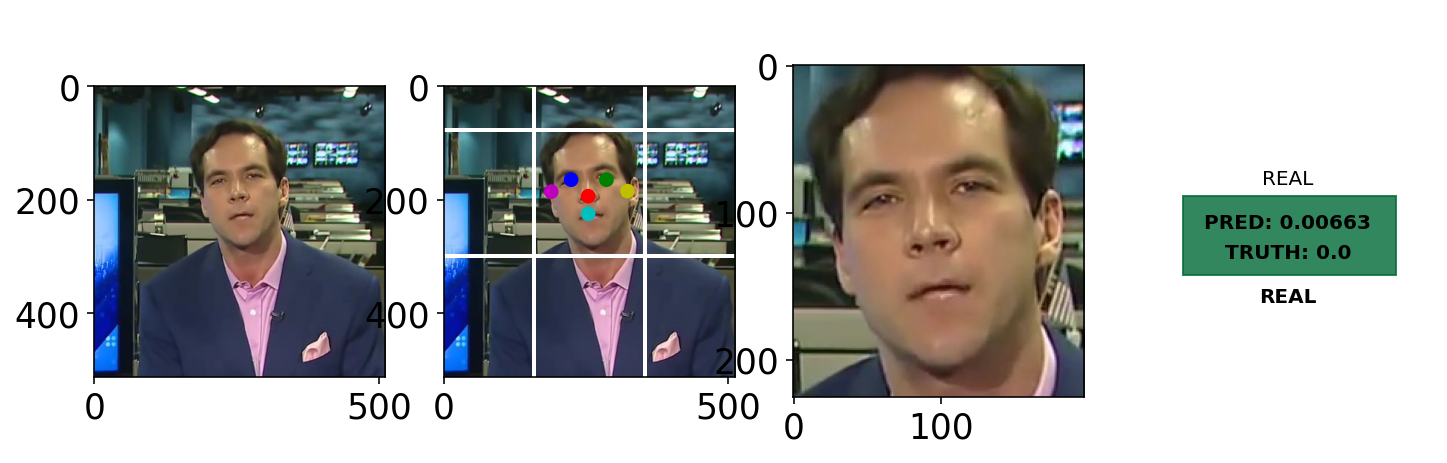

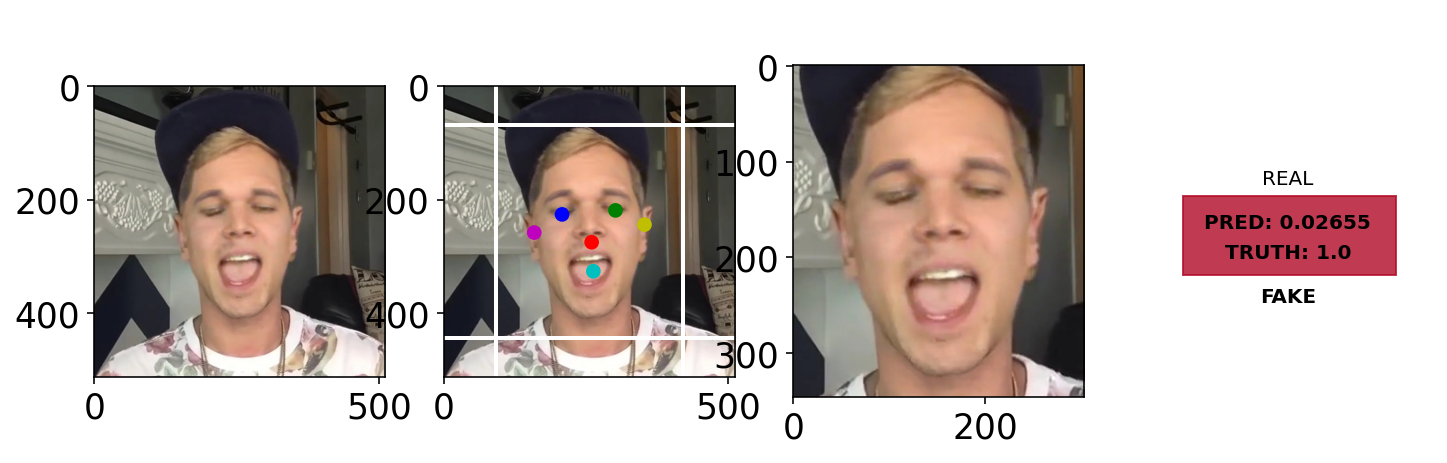

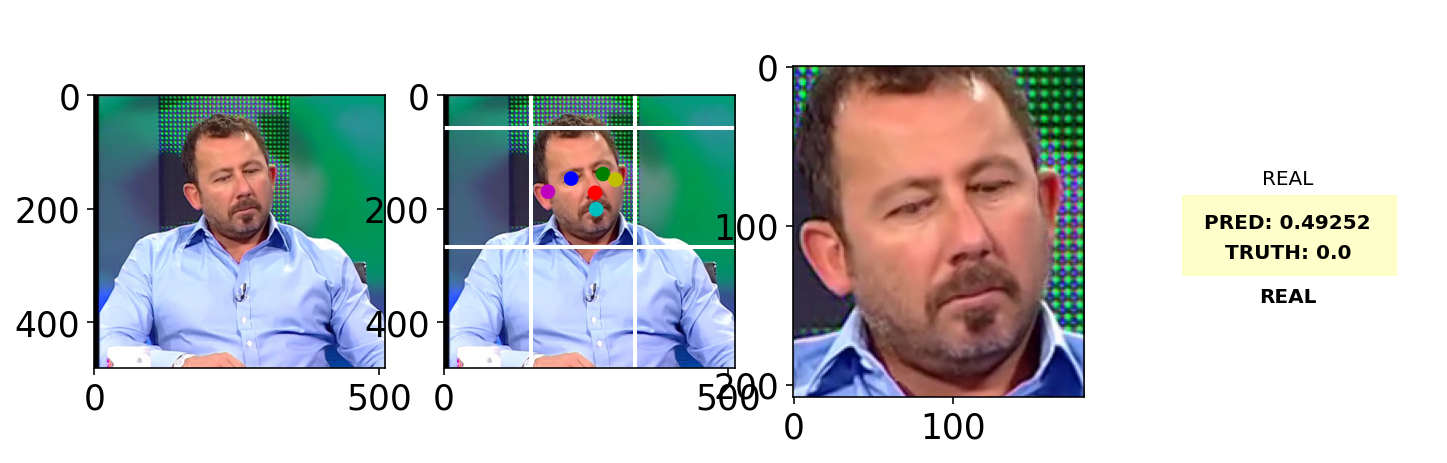

In [31]:
display_n_results(5, test_df, face_folder, all_truth, all_preds, face_extractor)

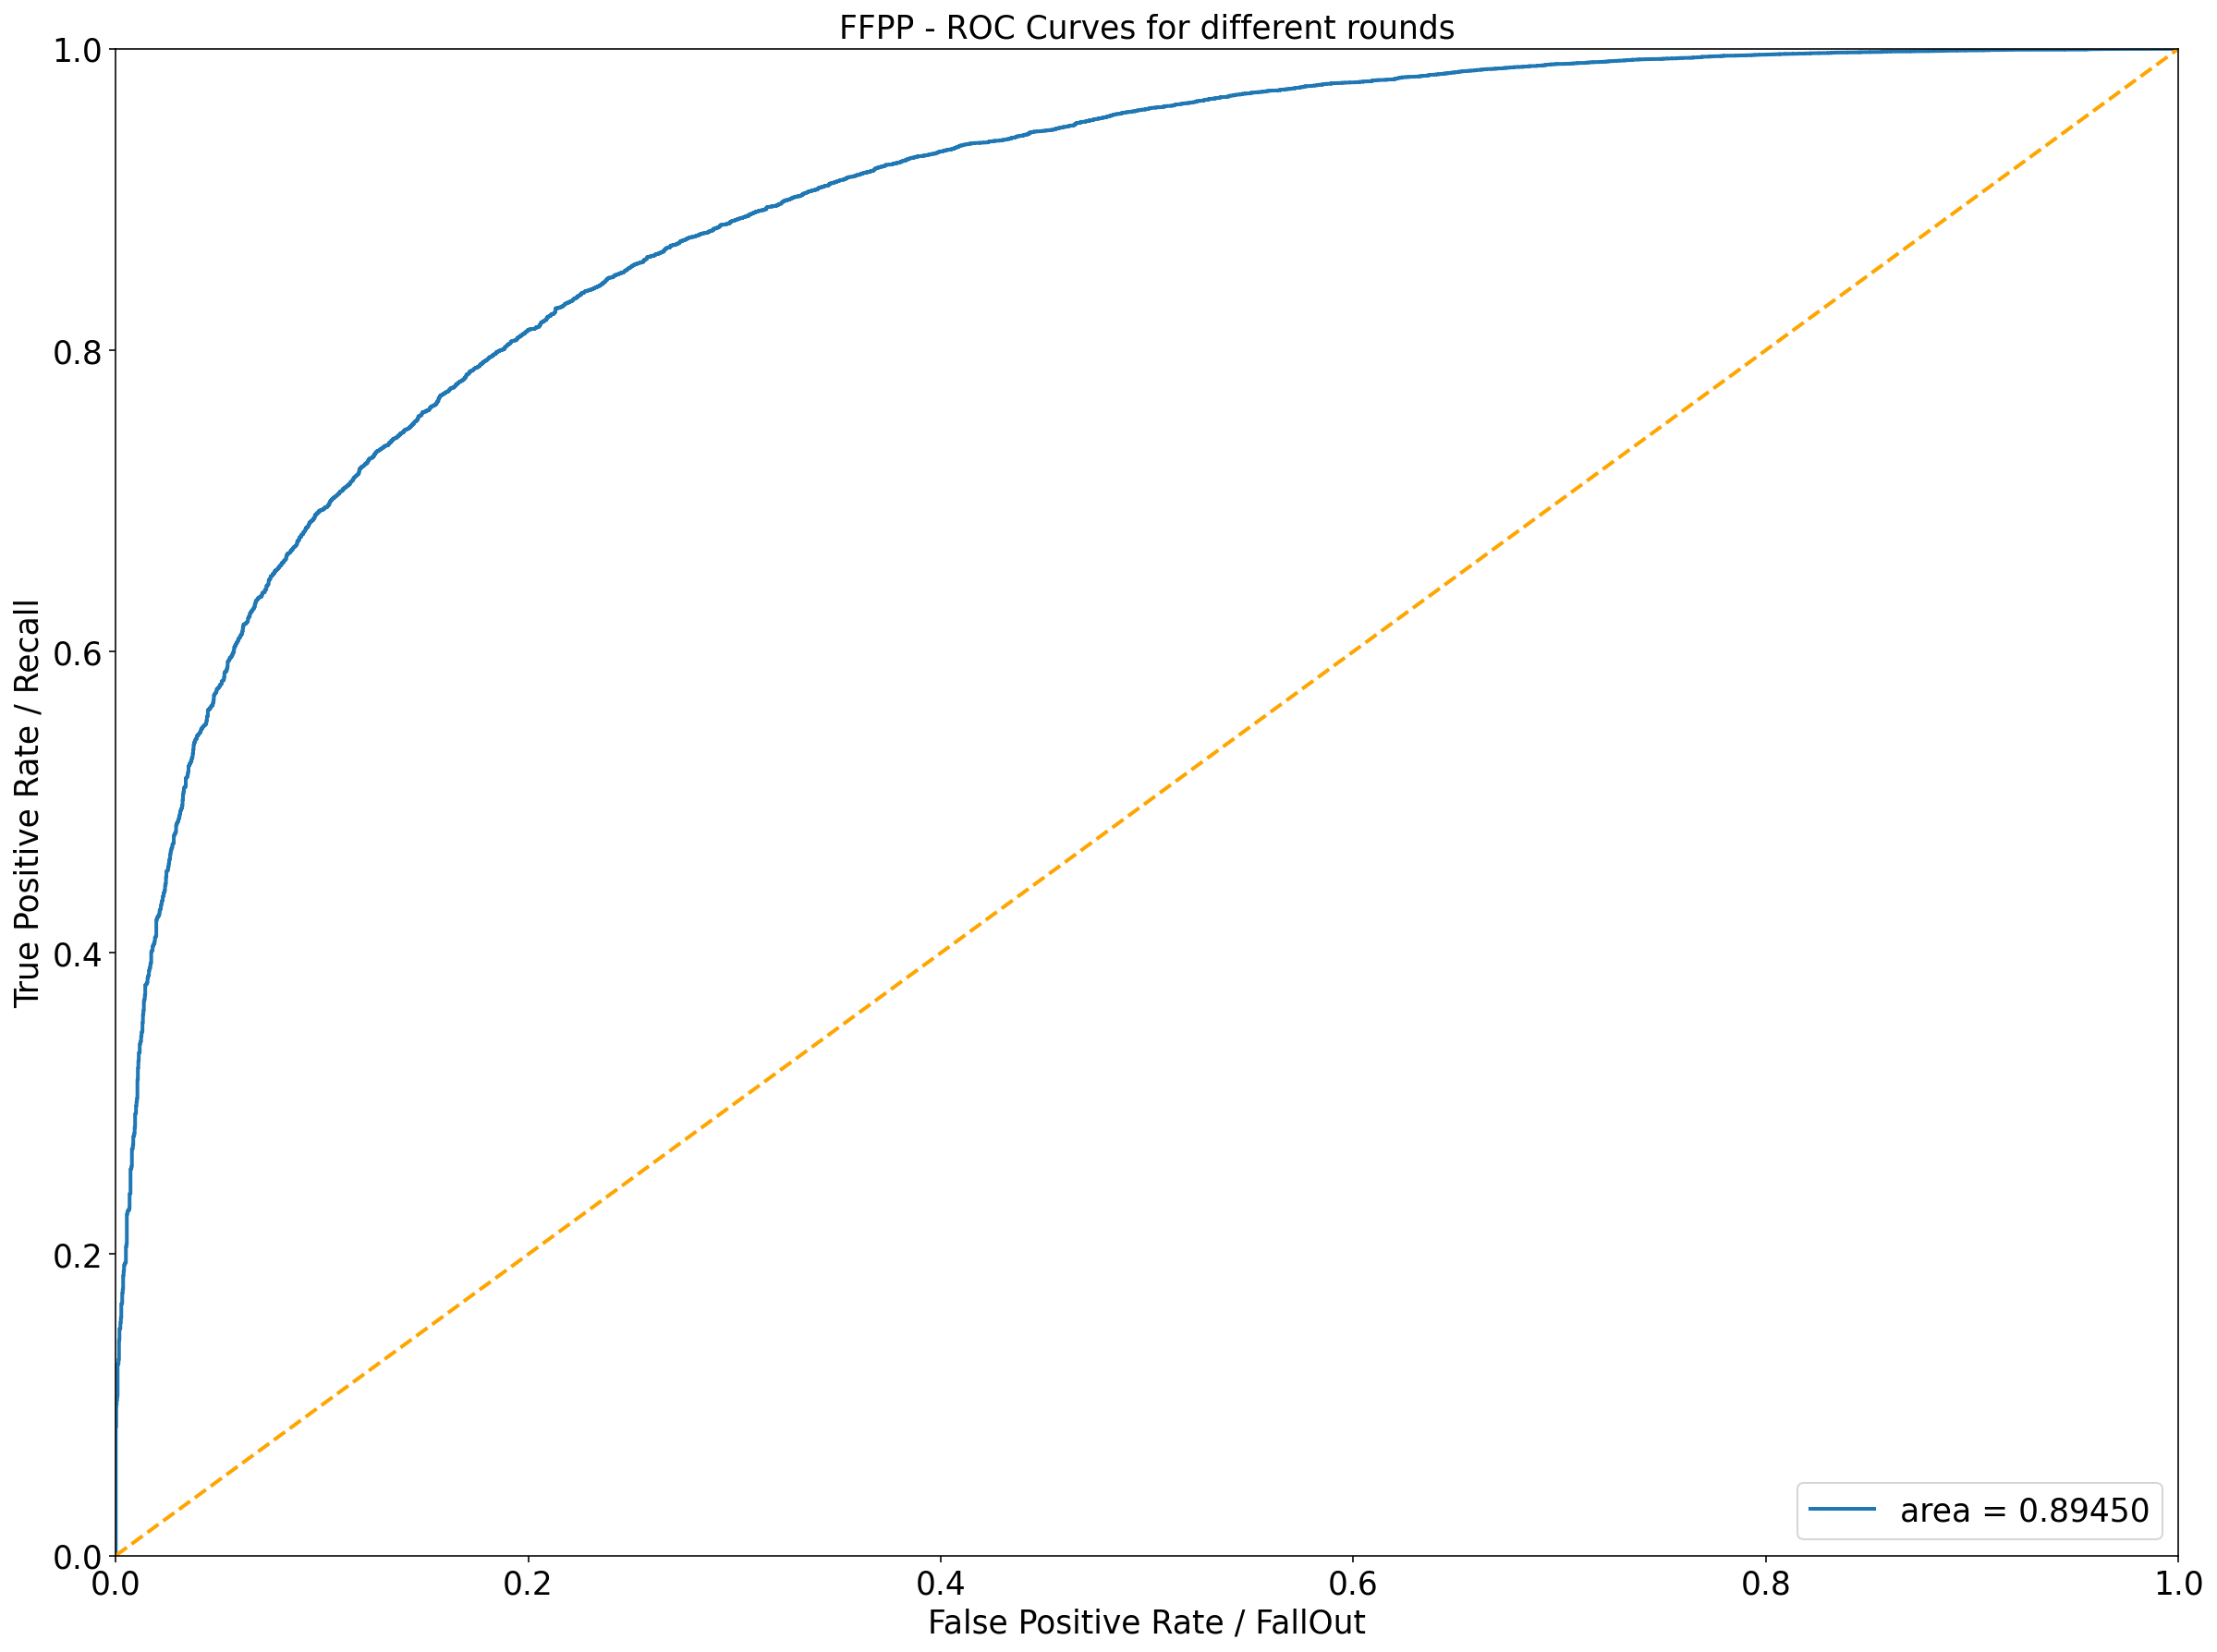

Accuracy:  0.7344023215149373
Precision: 0.970580979400518
Recall:    0.7025760078574936
F1-Score:  0.8151140807500065


In [32]:
plot_roc(ds, all_truth, all_preds)

## TEST TRICKS with preloaded w

In [ ]:
train_db = 'DFDC'
model_url = weights.weight_url['{:s}_{:s}'.format('EfficientNetB4',train_db)]
net = getattr(fornet,'EfficientNetB4')().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

In [ ]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

facedet = BlazeFace().to(device)
facedet.load_weights("blazeface/blazeface.pth")
facedet.load_anchors("blazeface/anchors.npy")
face_extractor = FaceExtractor(facedet=facedet)

# Get which images where used for test
test_folder = torch.load("weights/binclass/"+tag+"/bestval.pth", map_location=device)['test_videos_used']
test_folder = test_folder[0]

# Load the dataframe
face_folder = "output/"+ds+"/faces"
df = pd.read_pickle("output/"+ds+"/dfs/from_video_0_to_video_0.pkl")
test_df = df[df.video.isin(test_folder)]

# Load images and extract them
imgs_face = []
for index in tqdm(range(len(test_df))):
    path = face_folder+'/'+test_df.index[index]
    img = Image.open(path)
    img_faces = face_extractor.process_image(img=img)
    if len(img_faces['faces']) > 0:
        img_face = img_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace
    imgs_face.append(img_face)

In [ ]:
divisor=108
all_preds = []
for i in tqdm(range(len(test_df)//divisor)):
    faces_t = torch.stack([transf(image=im)['image'] for im in imgs_face[i*divisor:(i+1)*divisor]])
    with torch.no_grad():
        faces_pred = torch.sigmoid(net(faces_t.to(device))).cpu().numpy().flatten()
    all_preds.append(faces_pred)
all_preds = np.array([i for tab in all_preds for i in tab])

In [ ]:
import matplotlib.colorbar as cbar
import pylab as pl

show_n_first = 5
indices = np.random.choice(len(test_df), show_n_first, replace=False)
indices = np.array([int(i) for i in indices])

for index in indices:
    path = face_folder+'/'+test_df.index[index]
    img = Image.open(path)
    
    fig, ax = plt.subplots(1,4,figsize=(12,4))
    # Left image
    ax[0].imshow(img)

    # Central image
    ax[1].imshow(img)
    ax[1].scatter(x=[test_df.kp1x[index], test_df.kp2x[index], test_df.kp3x[index], test_df.kp4x[index], test_df.kp5x[index], test_df.kp6x[index]],
                  y=[test_df.kp1y[index], test_df.kp2y[index], test_df.kp3y[index], test_df.kp4y[index], test_df.kp5y[index], test_df.kp6y[index]],
                  c=['b','g', 'r','c', 'm', 'y'], s=40)
    ax[1].axhline(y=test_df.top[index], color='w', linestyle='-')
    ax[1].axhline(y=test_df.bottom[index], color='w', linestyle='-')
    ax[1].axvline(x=test_df.left[index], color='w', linestyle='-')
    ax[1].axvline(x=test_df.right[index], color='w', linestyle='-')

        # Right image
    img_faces = face_extractor.process_image(img=img)
    if len(img_faces['faces']) == 0:
        ax[2].text(0.5, 0.5, 'NO FACE DETECTED', horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)
    else:
        img_face = img_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace
        ax[2].imshow(img_face)
        
        pred = all_preds[index]
        truth = all_truth[index]
        ax[3].text(0.5, 0.52, 'PRED: '+str(round(pred, 5)), horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes, weight='bold')
        ax[3].text(0.5, 0.45, 'TRUTH: '+str(truth), horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes, weight='bold')
        if truth==1:
            txt='FAKE'
        else:
            txt='REAL'
        ax[3].text(0.5, 0.35, txt, horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes, weight='bold')
        if pred>0.5:
            txt='FAKE'
        else:
            txt='REAL'
        ax[3].text(0.5, 0.62, txt, horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes)

        ax[3].axis('off')
        normal = pl.Normalize(0,1)
        if truth==1:
            cm = pl.cm.RdYlGn
            colors = cm(normal(pred))
        else:
            cm = pl.cm.RdYlGn_r
            colors = cm(normal(pred))
        colors = (colors[0], colors[1], colors[2], 0.8)
        ax[3].add_patch(mpl.patches.Rectangle((0.14,0.4), 0.73, 0.18, color=colors))
        
    plt.show()

In [ ]:
ds = 'dfdc'
mpl.rcParams.update(mpl.rcParamsDefault)

fpr, tpr, _ = roc_curve(all_truth, all_preds)
roc_auc = auc(fpr, tpr)
    
plt.figure(figsize=(20, 15))

plt.plot(fpr, tpr, label='area = %0.5f' % roc_auc)

plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate / FallOut')
plt.ylabel('True Positive Rate / Recall')
plt.title(ds.upper()+' - ROC Curves for different rounds')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = all_truth
y_probas = np.array([1-np.array(all_preds), np.array(all_preds)]).T
skplt.metrics.plot_roc(y_true, y_probas)
plt.show()

In [ ]:
.shape

In [ ]:
net